In [38]:
import json
import requests
import flickrapi
import pandas as pd
from tqdm import tqdm
from vincenty import vincenty
import geopandas
import matplotlib.pyplot as plt
import contextily as ctx

In [39]:
api_key = u'b766ae533b2843f748b174f53885eee4'
api_secret = u'ac3884caa9690723'

In [40]:
flickr = flickrapi.FlickrAPI(api_key, api_secret)

In [41]:
flickr = flickrapi.FlickrAPI(api_key, api_secret, format='json')
photos = flickr.photos.search(per_page='250', bbox='20.410, 59.800, 30.920, 69.910', has_geo=1)
parsed = json.loads(photos.decode('utf-8'))

id = parsed['photos']['photo'][0]['id']
geo = flickr.do_flickr_call('flickr.photos.geo.getLocation', photo_id=id)
print(json.loads(geo.decode('utf-8')))


{'photo': {'id': '50973055081', 'location': {'latitude': '62.219084', 'longitude': '27.576615', 'accuracy': '16', 'context': '0', 'locality': {'_content': 'Joroinen'}, 'county': {'_content': 'Pieksämäki'}, 'region': {'_content': 'Southern Savonia'}, 'country': {'_content': 'Finland'}, 'neighbourhood': {'_content': 'Mökkikylä'}}}, 'stat': 'ok'}


## How we divide:
245 pages total:
    Veronica 1-120
    Ashish 121 - 240

In [43]:
photos_set = []
for i in tqdm(range(1,121)):
    res = flickr.photos.search(per_page='250', page=i, bbox='20.410, 59.800, 30.920, 69.910', has_geo=1)
    parsed = json.loads(res.decode('utf-8'))
    for p in parsed['photos']['photo']:
        photos_set.append(p)

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:59<00:00,  2.01it/s]


In [44]:
len(photos_set)

25602

In [45]:
photos_set[0]

{'id': '50973055081',
 'owner': '190414320@N06',
 'secret': '13bb10056e',
 'server': '65535',
 'farm': 66,
 'title': 'Kiekka (Maavesi) Hydroelectric Powerplant - Kiekan voimalaitos (Maaveden voimalaitos)',
 'ispublic': 1,
 'isfriend': 0,
 'isfamily': 0}

In [20]:
# photo_id, lat, lon, name, locality, neighbourhood
photo_ids = []
lats = []
longs = []
names = []
localities = []
neighbourhoods = []
regions = []
for p in tqdm(photos_set):
    photo_id = p['id']
    geo = flickr.do_flickr_call('flickr.photos.geo.getLocation', photo_id=photo_id)
    parsed = json.loads(geo.decode('utf-8'))
    ## construct arrays of data
    photo_ids.append(photo_id)
    names.append(p['title'])
    lats.append(parsed['photo']['location']['latitude'])
    longs.append(parsed['photo']['location']['longitude'])
    neighbourhoods.append(parsed['photo']['location']['neighbourhood']['_content'])
    regions.append(parsed['photo']['location']['region']['_content'])

  4%|███▎                                                                       | 1136/25440 [03:58<1:25:09,  4.76it/s]


KeyboardInterrupt: 

## Data collection strategy:
We collect geographical information on all pictures taken in Finland inside the BBOX 21.402542, 60.562697, 28.664383, 69.766582.
Then, we test various clusterization algorithms to create ~500 nodes where each node represents a location.
For each location we can find ot the number of pictures taken, the most common names and tags. 
The edge is represented by distance calculated with Vincenty formula.
UPD We look into whole Europe (bbox is -25.31, 35.17, 40.96, 71.33)

In [ ]:
df = pd.DataFrame({'id': photo_ids,
                  'name': names,
                  'lat': lats,
                  'lon': longs,
                  'locality': localities,
                  'neighbourhood': neighbourhoods})

In [94]:
df.to_csv('photoset.csv', index=False)

In [10]:
df = pd.read_csv('photoset.csv')
df.head()

,id,name,lat,lon,locality,neighbourhood,geometry
0,50966372106,Flowing,63.447933,26.673366,Pielavesi,Nousiala,POINT (26.673366 63.447933)
1,50965089143,Iisalmi,63.562122,27.188588,Iisalmi,Iisalmi,POINT (27.188588 63.562122)
2,50959607628,"Raholan Pyrkivä - Hyvinkään Ponteva, Miesten D...",61.508915,23.627547,Tampere,Tohloppi,POINT (23.627547 61.508915)
3,50959607383,"Raholan Pyrkivä - Hyvinkään Ponteva, Miesten D...",61.508915,23.627547,Tampere,Tohloppi,POINT (23.627547 61.508915)
4,50958988873,DJI_0987,61.105755,21.448102,Rauma,Sampaanala,POINT (21.448102 61.105755)


In [11]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.lon, df.lat))

C:\Users\blazhko\Anaconda3\envs\cn\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\Users\blazhko\Anaconda3\envs\cn\lib\site-packages\contextily\tile.py:632: UserWarning: The inferred zoom level of 23 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


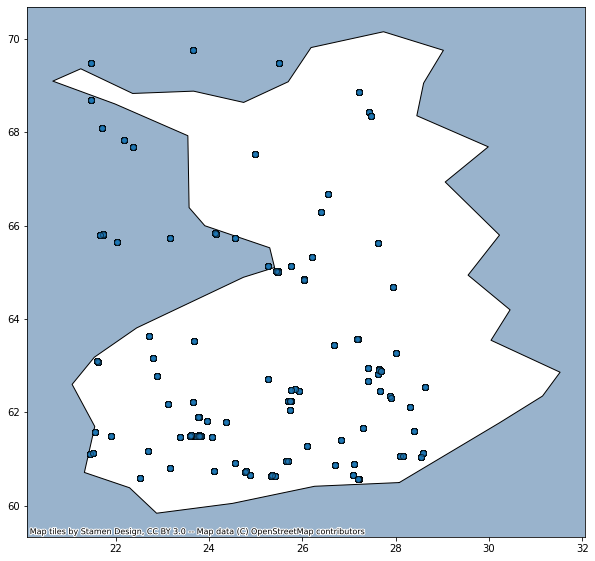

In [14]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'), bbox=(20.410, 59.800, 30.920, 69.910))

ax = world[world.name == 'Finland'].plot(figsize=(10, 10),
    color='white', edgecolor='black')
ctx.add_basemap(ax)
gdf.plot(ax=ax, alpha=0.5, edgecolor='k')

plt.show()